<div style=float:right><img src="assets/img/appliedai-logo.png" width=100 style="margin: 0px 20px"></img></div>


##### Jonathan Sedar Personal Project
## PyMC3 vs PyStan Comparison
_Spring 2016_

This set of Notebooks and scripts comprise the **pymc3_vs_pystan** personal project by Jonathan Sedar of Applied AI Ltd, written primarily for presentation at the PyData London 2016 Conference.

The project demonstrates hierarchical linear regression using two Bayesian inference frameworks: PyMC3 and PyStan. The project borrows heavily from code written for Applied AI Ltd and is supplied here for educational purposes only. No copyright or license is extended to users.


# 00_BasicInstallTests

#### Confirm that statsmodels, PyMC3, Theano and PyStan (Stan) all execute and behave as expected


+ [Setup](#Setup)
    + [Local Functions](#Local-Functions)
    + [Prepare Data](#Prepare-Data)


+ [Create OLS using statsmodels for reference](#Create-OLS-using-statsmodels-for-reference)


+ [Create OLS using PyMC3](#Create-OLS-using-PyMC3)

+ []()

# Setup

In [27]:
## Interactive magics
%matplotlib inline
%qtconsole --colors=linux
# %connect_info

In [28]:
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import patsy as pt
import statsmodels.api as sm

import pymc3 as pm
import theano as thno
import theano.tensor as T 
import pystan

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

In [29]:
print('Python: {}'.format(sys.version))
print('Recursion limit {}'.format(sys.getrecursionlimit()))
print('theano: {}'.format(thno.__version__))
print('PyMC3: {}'.format(pm.__version__))
print('pystan: {}'.format(pystan.__version__))

Python: 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Recursion limit 10000
theano: 0.8.2
PyMC3: 3.0
pystan: 2.8.0.0


## Local Functions

In [30]:
def strip_derived_rvs(rvs):
    '''Convenience fn: remove PyMC3-generated RVs from a list'''
    ret_rvs = []
    for rv in rvs:
        if not (re.search('_log',rv.name) or re.search('_interval',rv.name)):
            ret_rvs.append(rv)     
    return ret_rvs


## Prepare Data

We'll use the Hogg 2010 data available at  https://github.com/astroML/astroML/blob/master/astroML/datasets/hogg2010test.py  
It's a very small dataset so for convenience, it's hardcoded below.

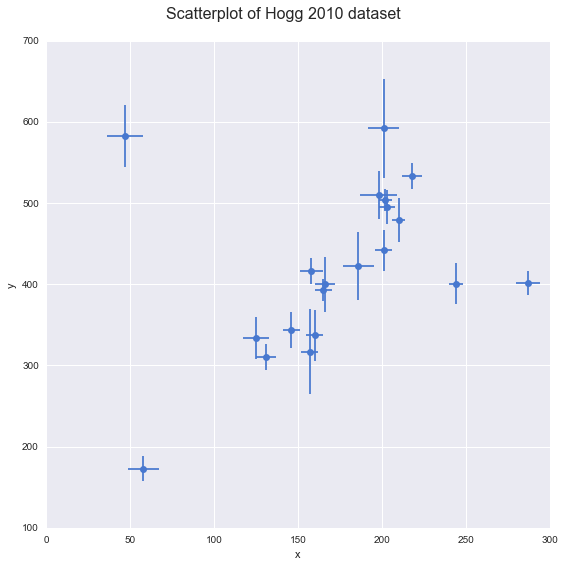

In [31]:
## cut & pasted directly from the fetch_hogg2010test() function in astroml package
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## scatterplot
g = sns.FacetGrid(dfhogg, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset', fontsize=16)

---

# Create OLS using statsmodels for reference

In [32]:
(mx_en, mx_ex) = pt.dmatrices('y ~ x + 1', dfhogg, return_type='dataframe', NA_action='raise')

In [33]:
smfit = sm.OLS(mx_en, mx_ex).fit()
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     2.473
Date:                Sun, 22 May 2016   Prob (F-statistic):              0.133
Time:                        12:22:37   Log-Likelihood:                -119.15
No. Observations:                  20   AIC:                             242.3
Df Residuals:                      18   BIC:                             244.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    310.0172     73.000      4.247      0.0

---

---

# Create OLS using PyMC3

##### Build model

In [34]:
with pm.Model() as mdl_ols:
    
    ## Define uninformative Uniform priors to give OLS
    b0 = pm.Uniform('b0_intercept', lower=-1e6, upper=1e6)
    b1 = pm.Uniform('b1_slope', lower=-1e6, upper=1e6)
 
    ## Define linear model
    yest = b0 + b1 * dfhogg['x']
    
    ## Define Normal likelihood with HalfNormal error
    epsilon = pm.HalfNormal('epsilon', 10)
    likelihood = pm.Normal('likelihood', mu=yest, sd=epsilon, observed=dfhogg['y'])


Applied interval-transform to b0_intercept and added transformed b0_intercept_interval to model.
Applied interval-transform to b1_slope and added transformed b1_slope_interval to model.
Applied log-transform to epsilon and added transformed epsilon_log to model.


##### Take samples using NUTS

In [35]:
with mdl_ols:

    ## find MAP using Powell, seems to be more robust
    start_MAP = pm.find_MAP(fmin=optimize.fmin_powell)

    ## take samples
    trc_ols = pm.sample(1000, start=start_MAP, njobs=4, step=pm.NUTS())

 [-----------------100%-----------------] 1000 of 1000 complete in 3.9 sec

##### View traceplots (full trace)

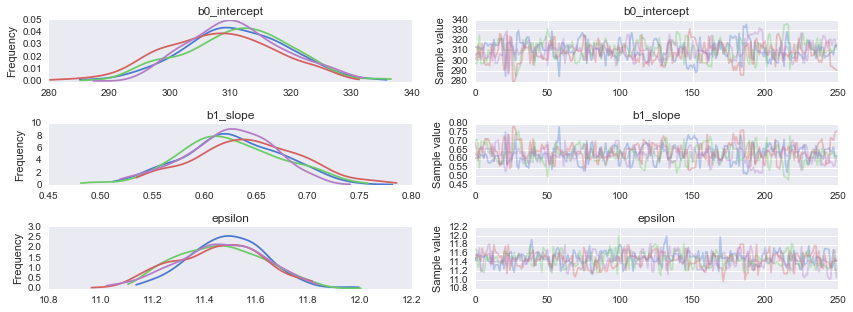

In [36]:
rvs_ols = [rv.name for rv in strip_derived_rvs(mdl_ols.unobserved_RVs)]
_ = pm.traceplot(trc_ols[-250:], varnames=rvs_ols, figsize=(12, len(rvs_ols)*1.5))

##### Take the final 1000 samples across all chains

In [37]:
print(pm.df_summary(trc_ols[-250:], varnames=rvs_ols))

                    mean        sd  mc_error     hpd_2.5    hpd_97.5
b0_intercept  310.356127  8.984907  0.464603  293.875295  327.099930
b1_slope        0.630146  0.048971  0.002551    0.532362    0.714143
epsilon        11.469153  0.165494  0.007585   11.168305   11.792997


/Users/volodymyrkazantsev/anaconda/envs/pymc3_vs_pystan/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


---

# Create OLS using PyStan

## Basic Modelspec, using default improper priors (uniform)

##### Define input dictionary

In [38]:
stan_datadict = {}
stan_datadict['N'] = mx_ex.shape[0]
stan_datadict['x'] = dfhogg['x'].values
stan_datadict['y'] = dfhogg['y'].values
stan_datadict.items()

dict_items([('N', 20), ('x', array([ 201.,  244.,   47.,  287.,  203.,   58.,  210.,  202.,  198.,
        158.,  165.,  201.,  157.,  131.,  166.,  160.,  186.,  125.,
        218.,  146.])), ('y', array([ 592.,  401.,  583.,  402.,  495.,  173.,  479.,  504.,  510.,
        416.,  393.,  442.,  317.,  311.,  400.,  337.,  423.,  334.,
        533.,  344.]))])

##### Define Model

In [39]:
stan_mdlspec_ols = """

    /* Very basic OLS on Hogg 2010 dataset */

    data {                                 
        int<lower=0> N;               // count of observations
        vector[N] x;                  // exog features
        vector[N] y;                  // endog feature
    }
    parameters {
        real alpha;                   // intercept (default uniform [-inf, inf])
        real beta;                    // slope (default uniform [-inf, inf])
        real<lower=0> sigma;          // model error (default uniform [0, inf])
    }
    model {  
        y ~ normal(alpha + beta * x, sigma);    // normal likelihood
    }
    """

##### Compile model and sample

In [40]:
stan_fit_ols = pystan.stan(model_code=stan_mdlspec_ols, data=stan_datadict,
                           iter=1000, warmup=750, chains=4, n_jobs=2,verbose=False)

/Users/volodymyrkazantsev/anaconda/envs/pymc3_vs_pystan/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/volodymyrkazantsev/anaconda/envs/pymc3_vs_pystan/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)


##### View traceplots

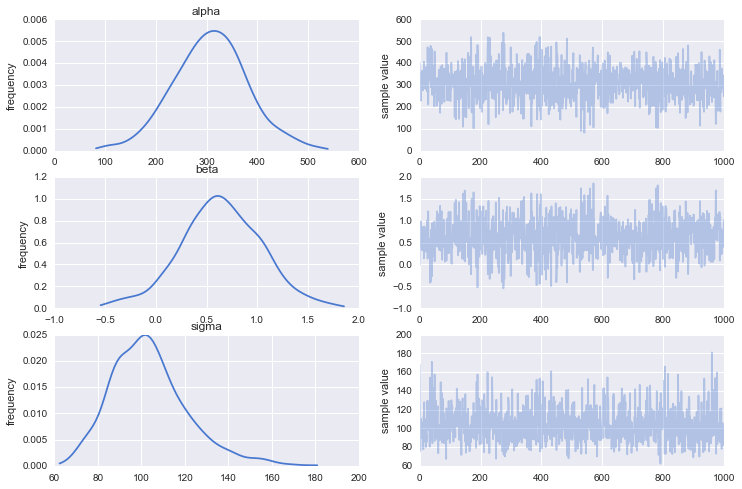

In [41]:
stan_fit_ols.plot(pars=['alpha', 'beta', 'sigma'])
plt.show()

##### View summary stats

In [42]:
print(stan_fit_ols)

Inference for Stan model: anon_model_ff2e15787e60f790c443a8b7e82fefa7.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha 308.18    2.34  74.05 159.93 260.58 309.55 355.23 463.16   1000   1.01
beta    0.64    0.01    0.4  -0.22   0.38   0.63   0.91   1.45   1000   1.01
sigma 103.64    0.56  17.65  74.43  90.79 101.85 112.87 146.03   1000    1.0
lp__  -97.67    0.04   1.26 -101.0  -98.2 -97.29 -96.75  -96.3   1000   1.01

Samples were drawn using NUTS(diag_e) at Sun May 22 12:23:26 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## Alternative modelspec

To demonstrate matrix input and explicit prior distributions

##### Define input dictionary

In [43]:
stan_datadict_alt = {}
stan_datadict_alt['N'] = dfhogg.shape[0]
stan_datadict_alt['K'] = 1
stan_datadict_alt['X'] = dfhogg[['x']].values
stan_datadict_alt['y'] = dfhogg['y'].values
stan_datadict_alt.items()

dict_items([('N', 20), ('X', array([[ 201.],
       [ 244.],
       [  47.],
       [ 287.],
       [ 203.],
       [  58.],
       [ 210.],
       [ 202.],
       [ 198.],
       [ 158.],
       [ 165.],
       [ 201.],
       [ 157.],
       [ 131.],
       [ 166.],
       [ 160.],
       [ 186.],
       [ 125.],
       [ 218.],
       [ 146.]])), ('y', array([ 592.,  401.,  583.,  402.,  495.,  173.,  479.,  504.,  510.,
        416.,  393.,  442.,  317.,  311.,  400.,  337.,  423.,  334.,
        533.,  344.])), ('K', 1)])

In [44]:
stan_mdlspec_ols_alt = """

    /* Very basic OLS on Hogg 2010 dataset */

    data {                                 
        int<lower=0> N;                       // count of observations
        int<lower=0> K;                       // count of exog features
        matrix[N, K] X;                       // exog features
        vector[N] y;                          // endog feature
    }
    parameters {
        real alpha;                           // intercept
        vector[K] beta;                       // exog params (N x 1 matrix)
        real<lower=0> sigma;                  // linear model error
    }
    transformed parameters {}
    model {  
        alpha ~ uniform(-100000, 100000);            // explicit prior for intercept
        beta[1] ~ uniform(-100000, 100000);         // explicit prior for slope
        sigma ~ normal(0, 10);                // explicit prior for error (halfnormal)
        y ~ normal(alpha + X * beta, sigma);  // define normal likelihood
    }
    generated quantities {}
    """

In [45]:
stan_fit_ols_alt = pystan.stan(model_code=stan_mdlspec_ols_alt, data=stan_datadict_alt,
                           iter=1000, warmup=750, chains=4, n_jobs=2, verbose=False)

/Users/volodymyrkazantsev/anaconda/envs/pymc3_vs_pystan/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/Users/volodymyrkazantsev/anaconda/envs/pymc3_vs_pystan/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)


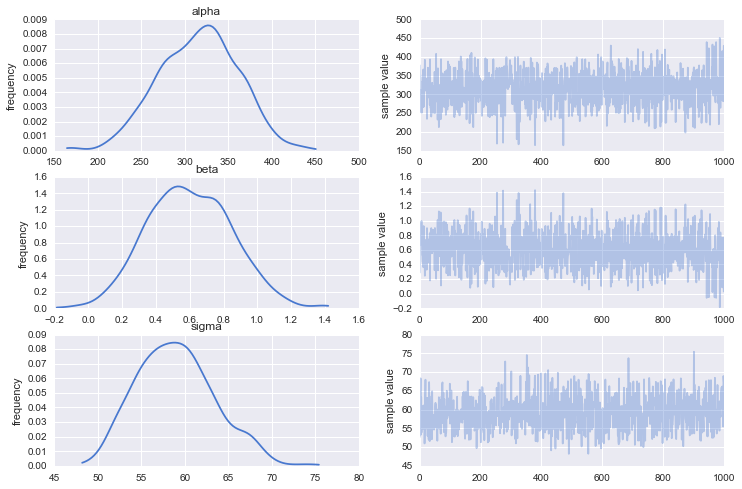

In [46]:
stan_fit_ols_alt.plot(pars=['alpha', 'beta', 'sigma'])
plt.show()

In [47]:
print(stan_fit_ols_alt)

Inference for Stan model: anon_model_c23d69e3c18fce26755f96f20a5f6cde.
4 chains, each with iter=1000; warmup=750; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=1000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha    315.6    1.44  45.54  226.2 283.04 317.81 346.73 398.73   1000    1.0
beta[0]    0.6  7.8e-3   0.25   0.14   0.42   0.59   0.77   1.09   1000    1.0
sigma    58.97    0.14   4.46  51.36  55.67  58.69  61.76  68.09   1000   1.01
lp__    -121.5    0.04    1.2 -124.8 -122.1 -121.2 -120.6 -120.1   1000   1.01

Samples were drawn using NUTS(diag_e) at Sun May 22 12:23:51 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


---
**Applied AI Ltd &copy; 2016**  
<a href='http://www.applied.ai'>applied.ai</a>